# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

## Load raw split frame

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scip_workflows.common import *

In [3]:
import pyarrow

## Load data

In [27]:
try:
    population_dir = Path(snakemake.input.population_dir)
    df = pq.read_table(snakemake.input.features).to_pandas()
    output = snakemake.output[0]
except NameError:
    data_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/wbc/")
    data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")
    data_dir = data_root / "scip" / "202204271347"
    population_dir = data_root / "meta/"
    output = data_dir / "labels.parquet"
    
    df = pq.read_table(data_dir / "features.parquet").to_pandas()

In [28]:
cat_type = CategoricalDtype(
    categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)

cat_type = CategoricalDtype(
    categories=sorted(df["meta_part"].astype(int).unique()), ordered=True)
df["meta_part"] = df["meta_part"].astype(int).astype(cat_type)

df = df.set_index(["meta_group", "meta_part", "meta_fix", "meta_object_number"])

In [29]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_files = list(Path(population_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}

    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        if ("early" in pop_file.stem) or ("late" in pop_file.stem):
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 3)+1:]
                        else:
                            pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 2)+1:]

In [30]:
def map_to_class(x):
    try:
        s = pops[x.meta_sample]
        return s[x.meta_object_number]
    except:
        return "unknown"

labels = pandas.concat([df.index.to_frame(), df["meta_sample"]], axis=1).apply(map_to_class, axis=1)
labels.name = "meta_label"

<AxesSubplot:xlabel='count', ylabel='meta_group'>

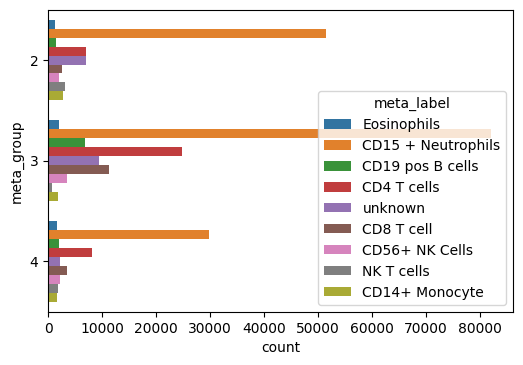

In [31]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=labels.reset_index(), y="meta_group", hue="meta_label")

In [32]:
labels.value_counts()

CD15 + Neutrophils    163421
CD4 T cells            39840
unknown                18560
CD8 T cell             17282
CD19 pos B cells       10438
CD56+ NK Cells          7744
CD14+ Monocyte          6207
NK T cells              5775
Eosinophils             4783
Name: meta_label, dtype: int64

In [33]:
df.shape

(274050, 2515)

In [34]:
pq.write_table(pyarrow.Table.from_pandas(labels.astype('category').to_frame()), output)